# Mise en place du notebook

## Versionning

P6 v7 : avant split entre "P6 part1 v01" (contient la récupération des données et le SIFT) et "P6 part2 v01" (contient VGG-16).  
P6 part2 : début VGG-16.
P6 part2 v03 : version ayant servi à la création de part 3.  
P6 part3 v01 : tf-idf sur les data.  
P6 part3 v02 : cleaning des data.    
P6 part3 v03 : Word2Vec.    
P6 part3 v04 : umap.  
P6 part3 v05 : criblage de clusterings.  

## Import des modules

In [49]:
# imports pour le développement
from pympler import asizeof
import mesfonctions
from importlib import reload
mesfonctions = reload(mesfonctions)

# imports pour la production
import warnings
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AffinityPropagation, MeanShift, Birch
from sklearn.manifold import TSNE 
from sklearn.metrics import adjusted_rand_score, rand_score, accuracy_score, silhouette_score, accuracy_score, confusion_matrix
from sklearn import decomposition, preprocessing, manifold
import pickle
from termcolor import colored, cprint
from mesfonctions import display_scree_plot, draw_tsne, draw_umap, accuracy_svm
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import disarray
import umap  # pip install umap-learn
import collections


## Fonctions courantes

In [2]:
def nom_fichier_photo(index, df=None):
    """Retourne le chemin + nom du fichier jpg d'une ligne de dataframe.
    Args : 
    - index : index de la ligne de df.
    Returns :
    - string.
    """
    if df is None:
        df = df_source
    return PATH + df['image'][index]

In [3]:
def creation_vecteurs_documents(model, dimension, documents):
    """Convertit un corpus de documents en une liste de vecteurs (un vecteur par document).
    Args :
    - model : modèle Word2Vec (type gensim.models.keyedvectors.KeyedVectors)
    - dimension : dimension du plongement Word2Vec.
    - documents : corpus de documents (itérables) sous forme de tokens (strings) 
    Returns :
    - arrays numpy de avec dimension colonnes et autant de lignes que de documents.
    """
    zero_vector = np.zeros(dimension)
    vecteurs_documents = []
    for document in documents:
        sum_feat_for_doc = np.zeros(dimension)
        count_for_doc = 0
        for token in document:
            if token in model:
                sum_feat_for_doc += model[token]
                count_for_doc += 1
        if (count_for_doc != 0):
            vecteur_document = sum_feat_for_doc / count_for_doc
            vecteurs_documents.append(vecteur_document)
        else:
            vecteurs_documents.append(zero_vector)
    return np.asarray(vecteurs_documents)

## Constantes

In [4]:
PATH = "Images_Flipkart/"

## Gestion des paramètres d'affichage de Jupyter

In [5]:
plt.style.use('seaborn')

warnings.filterwarnings(category=FutureWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

# Chargement du dataframe

In [6]:
df_source = pickle.load(open('df_source.pkl', 'rb'))
df_source

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,label,int_label
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,2
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,2
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,h

In [52]:
labels = ["Beauty and Personal Care", "Computers", "Baby Care", "Home Decor", "Home Furnishing", "Kitchen & Dining", "Watches"]

# Corpus utilisé

J'avais dans l'idée de créer un corpus de documents basé sur les variables product_name et product_specifications, mais c'est inutile car ils ont déjà été concaténés dans la variable description (note : le 861 y est bien ; c'est dû à une erreur dans le product_name, rectifié dans description).

In [7]:
for i in range(len(df_source)):
    if not (df_source['product_name'][i] in df_source['description'][i]):
        print(f"Il manque le produit numéro {i} dans description.")

Il manque le produit numéro 861 dans description.


Le corpus utilisé sera le suivant :

In [8]:
descriptions = df_source['description'].copy()

# Nettoyage du texte

Inspiré de : https://machinelearningmastery.com/clean-text-machine-learning-python/

In [9]:
def nettoyage_document(text, stemmed=True, output='tokens'):
    """ Tokenization et nettoyage d'un document :
    1) tokenization,
    2) casse = minuscule,
    3) suppression de la ponctuation,
    4) suppression des termes non alphabétiques,
    5) suppression des stop words,
    6) stemming (optionnel).
    Args :
    - text : string (document) à nettoyer.
    - output : string ('tokens' pour avoir des tokens en output, sinon l'output est un string des tokens concaténés)
    Returns :
    - texte nettoyé (sous forme de liste de strings (output='tokens'), ou de string reconcaténé)
    """
    # split into words
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    # stemming of words
    if stemmed:
        from nltk.stem.porter import PorterStemmer
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]
    
    # return
    if output == 'tokens':
        return words
    else:
        return ' '.join(words)


In [10]:
# test unitaire
texte = descriptions[0]
print(texte)
print('-'*50)
print(nettoyage_document(texte, stemmed=False, output='tokens'))

Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you 

## Texte nettoyé et "stemmed" (pour TfidfVectorizer)

In [11]:
descriptions_stemmed = descriptions.copy().map(lambda texte : nettoyage_document(texte, output='string'))

In [12]:
descriptions_stemmed

0       key featur eleg polyest multicolor abstract ey...
1       specif sathiya cotton bath towel bath towel re...
2       key featur eurospa cotton terri face towel set...
3       key featur santosh royal fashion cotton print ...
4       key featur jaipur print cotton floral king siz...
                              ...                        
1045    oren empow extra larg self adhes sticker pack ...
1046    wallmantra larg vinyl sticker sticker pack pri...
1047    buy uberlyf extra larg pigment polyvinyl film ...
1048    buy wallmantra medium vinyl sticker sticker on...
1049    buy uberlyf larg vinyl sticker onlin uberlyf l...
Name: description, Length: 1050, dtype: object

In [13]:
descriptions_stemmed[42]

'key featur mom kid babi girl print blue grey top pyjama set fabric cotton brand color blue grey mom kid babi girl print blue grey top pyjama set price rs girl pyjamaset specif mom kid babi girl print blue grey top pyjama set gener detail pattern print ideal babi girl night suit detail number content sale packag pack fabric cotton type top pyjama set neck round nack box top pyjama set'

## Texte nettoyé, sans stemming (pour Word2Vec, basé sur Google News 300)

In [14]:
descriptions_w2v = descriptions.copy().map(lambda texte : nettoyage_document(texte, stemmed=False, output='tokens'))

In [15]:
descriptions_w2v

0       [key, features, elegance, polyester, multicolo...
1       [specifications, sathiyas, cotton, bath, towel...
2       [key, features, eurospa, cotton, terry, face, ...
3       [key, features, santosh, royal, fashion, cotto...
4       [key, features, jaipur, print, cotton, floral,...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [buy, uberlyfe, extra, large, pigmented, polyv...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyfe, large, vinyl, sticker, online,...
Name: description, Length: 1050, dtype: object

In [16]:
print(descriptions_w2v[42])

['key', 'features', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'fabric', 'cotton', 'brand', 'color', 'blue', 'grey', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'price', 'rs', 'girls', 'pyjamaset', 'specifications', 'mom', 'kid', 'baby', 'girl', 'printed', 'blue', 'grey', 'top', 'pyjama', 'set', 'general', 'details', 'pattern', 'printed', 'ideal', 'baby', 'girl', 'night', 'suit', 'details', 'number', 'contents', 'sales', 'package', 'pack', 'fabric', 'cotton', 'type', 'top', 'pyjama', 'set', 'neck', 'round', 'nack', 'box', 'top', 'pyjama', 'set']


## Texte nettoyé et stemmed (pour Word2Vec, entrainement sur dataset Flipkart)

In [17]:
descriptions_w2v_fk = descriptions.copy().map(lambda texte : nettoyage_document(texte, stemmed=True, output='tokens'))

In [18]:
descriptions_w2v_fk

0       [key, featur, eleg, polyest, multicolor, abstr...
1       [specif, sathiya, cotton, bath, towel, bath, t...
2       [key, featur, eurospa, cotton, terri, face, to...
3       [key, featur, santosh, royal, fashion, cotton,...
4       [key, featur, jaipur, print, cotton, floral, k...
                              ...                        
1045    [oren, empow, extra, larg, self, adhes, sticke...
1046    [wallmantra, larg, vinyl, sticker, sticker, pa...
1047    [buy, uberlyf, extra, larg, pigment, polyvinyl...
1048    [buy, wallmantra, medium, vinyl, sticker, stic...
1049    [buy, uberlyf, larg, vinyl, sticker, onlin, ub...
Name: description, Length: 1050, dtype: object

In [19]:
print(descriptions_w2v_fk[42])

['key', 'featur', 'mom', 'kid', 'babi', 'girl', 'print', 'blue', 'grey', 'top', 'pyjama', 'set', 'fabric', 'cotton', 'brand', 'color', 'blue', 'grey', 'mom', 'kid', 'babi', 'girl', 'print', 'blue', 'grey', 'top', 'pyjama', 'set', 'price', 'rs', 'girl', 'pyjamaset', 'specif', 'mom', 'kid', 'babi', 'girl', 'print', 'blue', 'grey', 'top', 'pyjama', 'set', 'gener', 'detail', 'pattern', 'print', 'ideal', 'babi', 'girl', 'night', 'suit', 'detail', 'number', 'content', 'sale', 'packag', 'pack', 'fabric', 'cotton', 'type', 'top', 'pyjama', 'set', 'neck', 'round', 'nack', 'box', 'top', 'pyjama', 'set']


# Vectorisation par TF-IDF

Inspiré de :  https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

## Dataset non nettoyé

### CountVectorizer()

In [20]:
vectorizer = CountVectorizer(
#                              max_features=500,
                             stop_words='english',
                             min_df=10,  # le terme doit être présent dans >=10 documents
                             max_df=0.1   # le terme doit être présent dans <=10% des documents
                             )
vectorized = vectorizer.fit_transform(descriptions)

print("Nb de features :", vectorizer.get_feature_names_out().shape[0], "\n")

print("Features :\n", vectorizer.get_feature_names_out(), "\n")

print(vectorized.toarray())

vectorized

Nb de features : 522 

Features :
 ['10' '100' '12' '13' '14' '15' '150' '16' '17' '175' '18' '19' '199' '20' '200' '220' '225' '250' '299' '300' '329' '330' '349' '350' '399' '40' '45' '499' '50'
 '549' '550' '599' '5v' '60' '699' '75' '750' '799' '800' '899' '90' '999' 'abstract' 'ac' 'accessories' 'actual' 'adapter' 'add' 'additional' 'adorable'
 'affordable' 'age' 'air' 'aluminium' 'antique' 'apple' 'apply' 'area' 'aroma' 'art' 'assured' 'attractive' 'audio' 'authentication' 'available' 'baby' 'bag' 'base'
 'based' 'bath' 'battery' 'beautiful' 'beautifully' 'beauty' 'bed' 'bedroom' 'bedsheet' 'black' 'blanket' 'bleach' 'blue' 'body' 'bottle' 'boy' 'boys' 'brass'
 'break' 'bring' 'brings' 'broadcast' 'brown' 'buckle' 'bulb' 'button' 'cable' 'capacity' 'care' 'carry' 'case' 'casual' 'catchy' 'caused' 'ce' 'cell' 'center'
 'ceramic' 'certifications' 'charge' 'charger' 'check' 'checkered' 'cheer' 'clasp' 'classic' 'clean' 'closure' 'cloth' 'cms' 'code' 'coffee' 'cold' 'collection'
 'co

<1050x522 sparse matrix of type '<class 'numpy.int64'>'
	with 12541 stored elements in Compressed Sparse Row format>

In [21]:
print(vectorized)

  (0, 370)	6
  (0, 325)	4
  (0, 42)	4
  (0, 192)	6
  (0, 172)	5
  (0, 146)	9
  (0, 203)	1
  (0, 241)	2
  (0, 39)	1
  (0, 294)	1
  (0, 1)	1
  (0, 243)	1
  (0, 460)	1
  (0, 313)	1
  (0, 304)	1
  (0, 407)	2
  (0, 183)	2
  (0, 246)	2
  (0, 160)	1
  (0, 466)	1
  (0, 135)	1
  (0, 320)	2
  (0, 223)	1
  (0, 516)	1
  (0, 449)	1
  :	:
  (1046, 504)	2
  (1046, 59)	2
  (1046, 254)	2
  (1046, 397)	2
  (1046, 182)	4
  (1046, 278)	1
  (1046, 496)	4
  (1046, 456)	4
  (1046, 493)	3
  (1046, 56)	8
  (1046, 492)	2
  (1046, 377)	2
  (1046, 188)	2
  (1046, 186)	2
  (1046, 436)	2
  (1046, 244)	2
  (1046, 418)	2
  (1047, 278)	2
  (1047, 456)	2
  (1048, 310)	2
  (1048, 456)	4
  (1048, 493)	2
  (1049, 278)	2
  (1049, 456)	2
  (1049, 493)	2


In [22]:
terms = vectorizer.get_feature_names_out()
terms[520]

'yellow'

In [23]:
len(vectorizer.stop_words_)

5321

### TfidfTransformer()

In [24]:
transformer = TfidfTransformer()
X = transformer.fit_transform(vectorized)
X

<1050x522 sparse matrix of type '<class 'numpy.float64'>'
	with 12541 stored elements in Compressed Sparse Row format>

In [25]:
transformer.idf_

array([4.31991121, 3.9144461 , 4.46098981, 5.5596021 , 4.82200315, 4.62529286, 5.06712561, 4.9617651 , 5.24944717, 5.47259072, 4.9617651 , 5.39254801, 4.26861792,
       5.31844004, 5.47259072, 5.5596021 , 5.24944717, 5.18490865, 4.40214931, 4.86645492, 5.47259072, 5.06712561, 5.39254801, 4.49176147, 4.46098981, 5.24944717,
       5.5596021 , 4.62529286, 4.6616605 , 5.39254801, 5.39254801, 4.6616605 , 5.5596021 , 5.12428403, 5.01305839, 5.24944717, 5.47259072, 5.01305839, 5.12428403,
       5.24944717, 5.39254801, 4.37397843, 4.19629726, 5.24944717, 5.06712561, 5.06712561, 5.24944717, 4.59020154, 3.51484611, 5.18490865, 5.24944717, 5.31844004,
       5.5596021 , 5.31844004, 5.47259072, 5.47259072, 5.06712561, 5.12428403, 5.39254801, 4.73862155, 5.31844004, 4.73862155, 5.47259072, 5.39254801, 4.9617651 ,
       3.36237752, 5.18490865, 5.39254801, 5.5596021 , 4.55629999, 4.17330774, 4.2439253 , 4.77944354, 5.47259072, 4.9617651 , 5.18490865, 5.39254801, 3.65343228,
       4.59020154, 4.4

### Vectorisation par TfidfVectorizer()

TfidfVectorizer fait en one-pot les étapes de CountVectorizer et TfidfTransformer.  
Un avantage supplémentaire est qu'il conserve les feature names (cf. get_feature_names_out())

In [26]:
# le meilleur ARI est obtenu en filtrant le moins de mots (pas de stop words)
vectorizer = TfidfVectorizer(
#                              max_features=500,
#                              stop_words='english',
#                              min_df=10,  # le terme doit être présent dans >=10 documents
#                              max_df=0.1   # le terme doit être présent dans <=10% des documents
                             )

X = vectorizer.fit_transform(descriptions)
print("n_samples: %d, n_features: %d" % X.shape)
X

n_samples: 1050, n_features: 6053


<1050x6053 sparse matrix of type '<class 'numpy.float64'>'
	with 46143 stored elements in Compressed Sparse Row format>

In [27]:
terms = vectorizer.get_feature_names_out()
terms[2001]

'defined'

### Clustering par KMeans()

In [28]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=100)
km.fit(X)
cprint("Adjusted Rand Index: %.2f" %
      adjusted_rand_score(df_source['label'], km.labels_), 'red')
print("Rand Index: %.2f" % rand_score(df_source['label'], km.labels_))

Adjusted Rand Index: 0.27
Rand Index: 0.79


In [29]:
km.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       ...,
       [0.00018845, 0.00032755, 0.00071479, ..., 0.0001967 , 0.00090199, 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        , 0.        ]])

In [30]:
km.cluster_centers_.argsort()  # les coordonnées (des centres des clusters) sont triées de la plus petite à la plus grande

array([[   0, 3976, 3975, ..., 3678,  934, 5874],
       [   0, 4013, 4012, ..., 2576, 1702, 1061],
       [   0, 4010, 4009, ...,  939, 5566, 3804],
       ...,
       [6052, 4127, 4130, ...,  939, 5497, 3984],
       [   0, 3888, 3887, ..., 2054, 2752, 1113],
       [   0, 3938, 3937, ..., 5007, 1231, 4408]], dtype=int64)

In [31]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]   # les coordonnées (des centres des clusters) sont triées de la plus grande à la plus petite
order_centroids

array([[5874,  934, 3678, ..., 3975, 3976,    0],
       [1061, 1702, 2576, ..., 4012, 4013,    0],
       [3804, 5566,  939, ..., 4009, 4010,    0],
       ...,
       [3984, 5497,  939, ..., 4130, 4127, 6052],
       [1113, 2752, 2054, ..., 3887, 3888,    0],
       [4408, 1231, 5007, ..., 3937, 3938,    0]], dtype=int64)

In [32]:
for i in range(7):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: watch analog men at only discounts women india great for
Cluster 1: at com flipkart genuine shipping cash delivery buy free products
Cluster 2: mug to and it ceramic rockmantra your coffee perfect loved
Cluster 3: com flipkart only from guarantee 30 replacement day shipping genuine
Cluster 4: of the and to in cm your is with you
Cluster 5: baby girl details of fabric dress boy cotton sleeve neck
Cluster 6: prices best showpiece with online cm at 30 guarantee day


Trop de mots inutiles ici : le fait de conserver tous les mots pour maximiser l'ARI conduit à avoir des "stop words" dans les mots clés.

### Réduction de dimension (PCA) et visualisation par t-SNE

On fait une réduction de dimension par PCA au préalable (conservation de 99% de l'inertie).

Dimensions dataset avant réduction PCA :  (1050, 6053)
Dimensions dataset après réduction PCA :  (1050, 929)


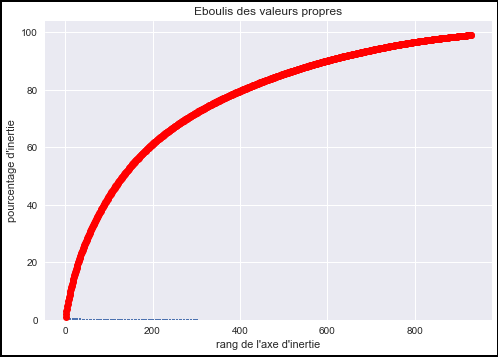

In [33]:
print("Dimensions dataset avant réduction PCA : ", X.shape)
pca = decomposition.PCA(n_components=0.99)
X_dense = csr_matrix.todense(X)   # convertit une sparse matrix en dense matrix 
X_scaled = preprocessing.StandardScaler().fit_transform(X_dense)   # données centrées réduites
feat_pca= pca.fit_transform(X_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

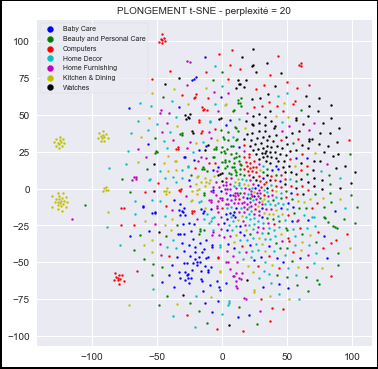

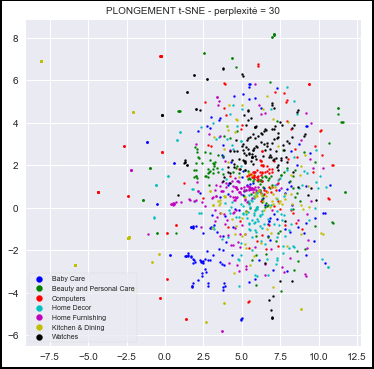

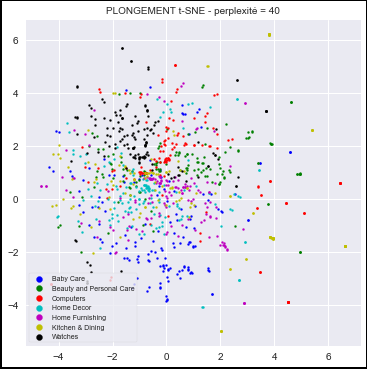

In [34]:
perplexities = [20, 30, 40]

draw_tsne(feat_pca, perplexities, df_source['label'])

## Dataset nettoyé

### Vectorisation par TfidfVectorizer()

In [35]:
# le meilleur ARI est obtenu en filtrant le moins de mots (pas de stop words)
vectorizer = TfidfVectorizer(
#                              max_features=500,
#                              stop_words='english',
                             min_df=10,  # le terme doit être présent dans >=10 documents
#                              max_df=0.1   # le terme doit être présent dans <=10% des documents
                             )

X = vectorizer.fit_transform(descriptions_stemmed)
print("n_samples: %d, n_features: %d" % X.shape)
X

n_samples: 1050, n_features: 542


<1050x542 sparse matrix of type '<class 'numpy.float64'>'
	with 26178 stored elements in Compressed Sparse Row format>

### Clustering par KMeans()

In [36]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=200, tol=1e-10)
km.fit(X)
cprint("Adjusted Rand Index: %.2f" %
      adjusted_rand_score(df_source['label'], km.labels_), 'red')
print("Adjusted Rand Index: %.2f" % rand_score(df_source['label'], km.labels_))

Adjusted Rand Index: 0.30
Adjusted Rand Index: 0.80


In [37]:
terms = vectorizer.get_feature_names_out()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]   # les coordonnées (des centres des clusters) sont triées de la plus grande à la plus petite
for i in range(7):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: cm warranti color pack design box featur model type cover
Cluster 1: flipkartcom cash genuin ship deliveri free rs buy product abstract
Cluster 2: watch analog men discount india great women flipkartcom onlin guarante
Cluster 3: showpiec best cm onlin guarante replac day price genuin cash
Cluster 4: mug ceram prithish coffe perfect gift rockmantra love one design
Cluster 5: flipkartcom guarante replac day cash genuin ship deliveri buy free
Cluster 6: babi girl detail fabric dress cotton boy sleev neck print


Les 'stop words' usuels ont disparu, mais l'ARI n'a pas été amélioré.

### Visualisation par t-SNE et UMAP

On fait une réduction de dimension par PCA au préalable (conservation de 99% de l'inertie).

Dimensions dataset avant réduction PCA :  (1050, 542)
Dimensions dataset après réduction PCA :  (1050, 379)


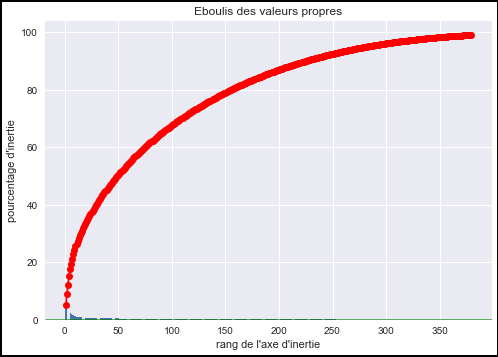

In [38]:
print("Dimensions dataset avant réduction PCA : ", X.shape)
pca = decomposition.PCA(n_components=0.99)
X_dense = csr_matrix.todense(X)   # convertit une sparse matrix en dense matrix 
X_scaled = preprocessing.StandardScaler().fit_transform(X_dense)   # données centrées réduites
feat_pca= pca.fit_transform(X_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

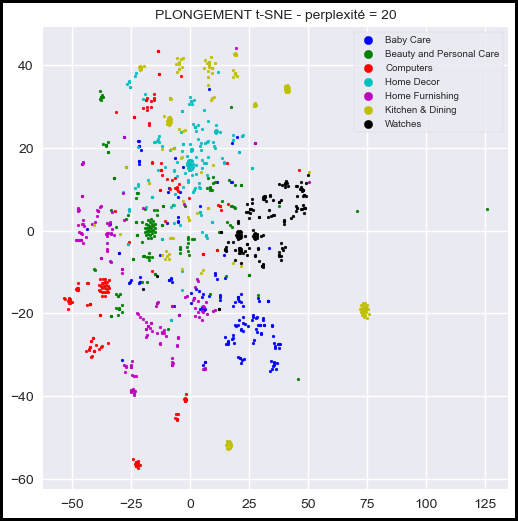

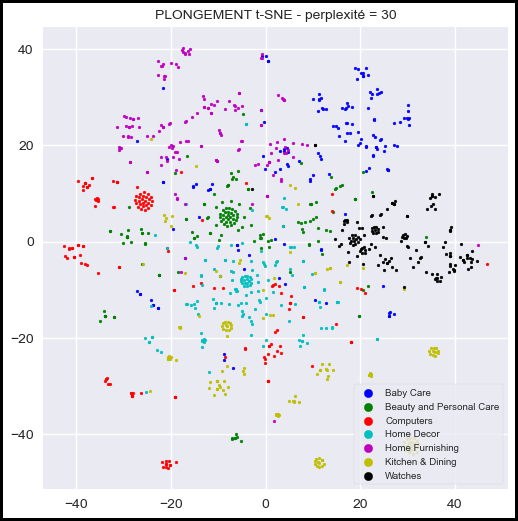

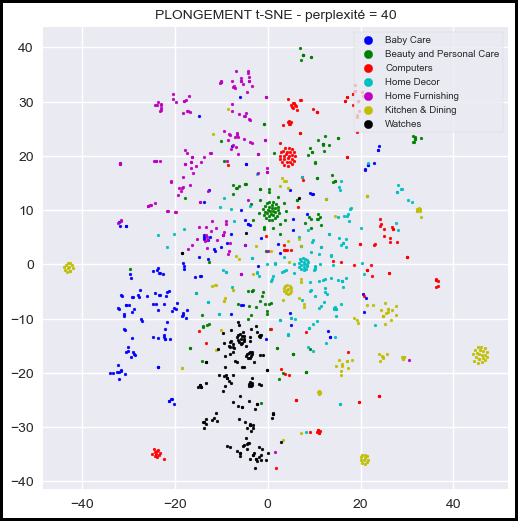

In [1737]:
perplexities = [20, 30, 40]
plt.style.use('seaborn')
draw_tsne(feat_pca, perplexities, df_source['label'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



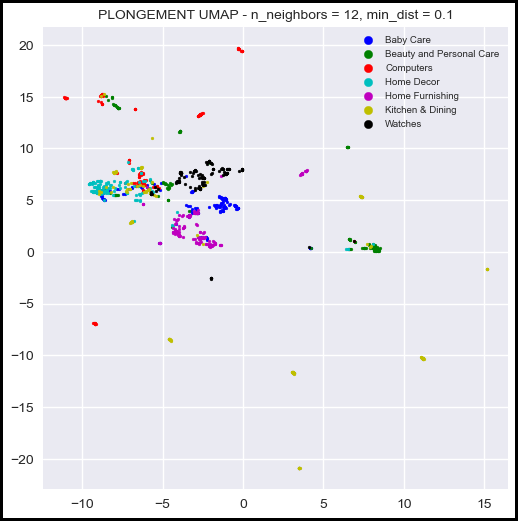

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



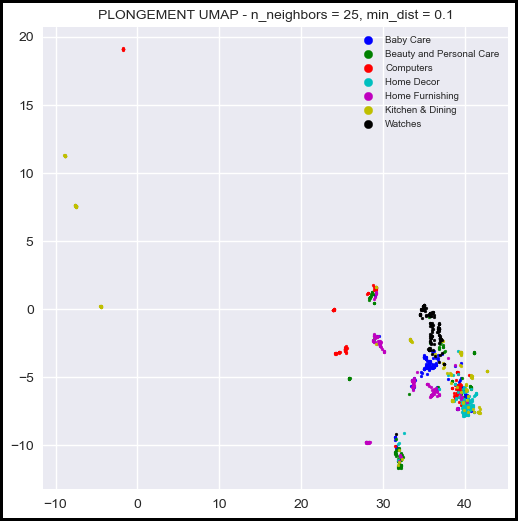

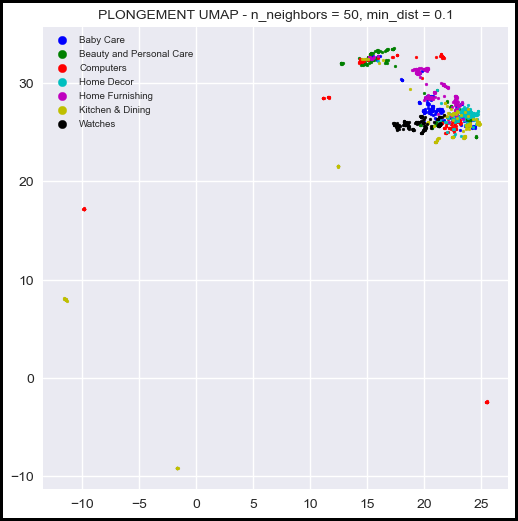

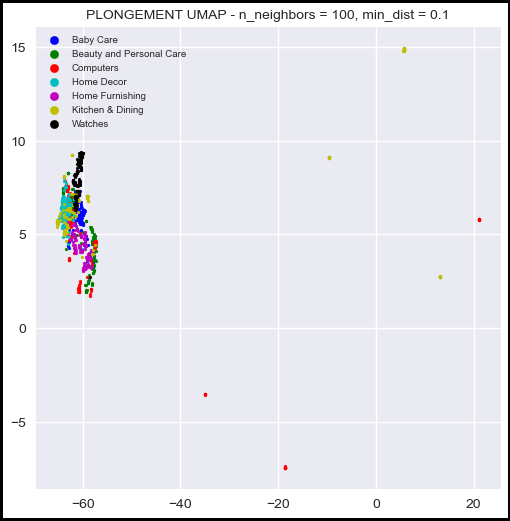

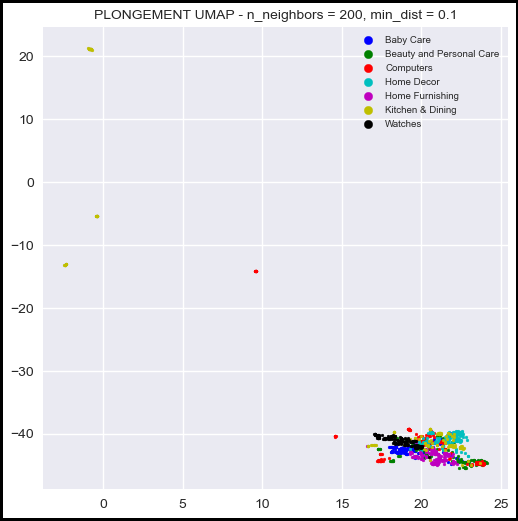

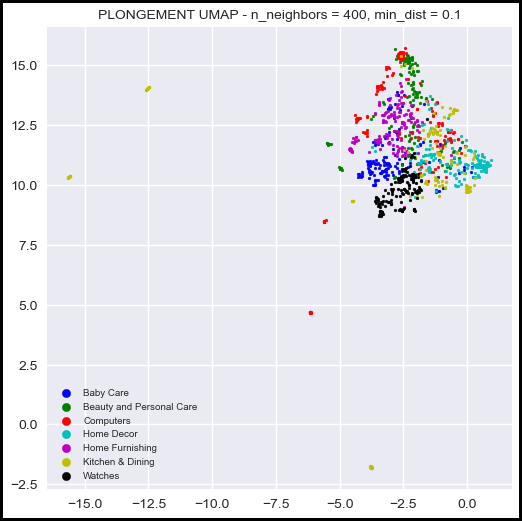

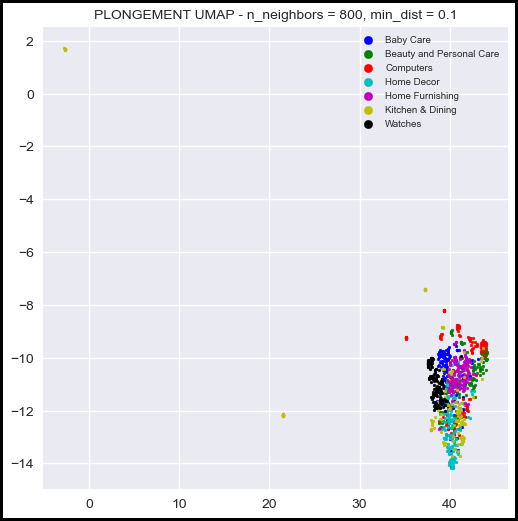

In [1736]:
for n_neighbors in (12, 25, 50, 100, 200, 400, 800):
    draw_umap(feat_pca, df_source['label'], n_neighbors)

### Classification par SVM

In [1966]:
accuracy_svm(feat_pca, df_source['int_label'], n_run=100)

Accuracy : moyenne = 0.88, écart-type = 0.02


# Vectorisation par Word2Vec

## Modèle préentrainé (Google news vector)

Les mots de ce modèle préentrainé ne sont pas stemmed => notre texte ne devra pas être stemmed.  
  
Méthodologie inspirée de https://github.com/practical-nlp/practical-nlp-code/blob/master/Ch4/03_Word2Vec_Example.ipynb (mais le code de ce repo est bourré de bugs).  

Chaque terme de notre dataset est converti en un vecteur par le modèle Word2Vec préentrainé.  
Puis pour chaque document (donc chaque objet Flipkart) de notre dataset, on fait la moyenne des vecteurs de mots pour avoir un vecteur de document.

### Vectorisation

###### Chargement du modèle

In [41]:
try:
    gn300_model
except NameError:
    from gensim.models import KeyedVectors
    filename = 'GoogleNews-vectors-negative300.bin'
    gn300_model = KeyedVectors.load_word2vec_format(filename, binary=True)
    dimension = 300

In [43]:
descriptions_w2v_vectorized = creation_vecteurs_documents(gn300_model, dimension=300, documents=descriptions_w2v)
descriptions_w2v_vectorized.shape

(1050, 300)

### Réduction de dimension PCA

Il vaut mieux éviter de faire une réduction de dimension sur ce dataset de 300 variables.  
Avantage : on passe de 300 à 223 dimensions (en conservant 99% de l'inertie).  
Inconvénient : le dataset réduit ne permet plus d'accéder aux propriétés et méthodes des datasets word2vec.  

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 223)


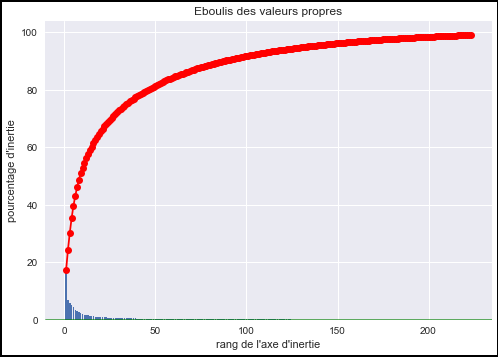

In [44]:
print("Dimensions dataset avant réduction PCA : ", descriptions_w2v_vectorized.shape)
pca = decomposition.PCA(n_components=0.99)
X_scaled = preprocessing.StandardScaler().fit_transform(descriptions_w2v_vectorized)   # données centrées réduites
feat_pca= pca.fit_transform(X_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

### Clustering

#### KMeans()

In [45]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=100, tol=1e-10)
km.fit(descriptions_w2v_vectorized)
cprint("Adjusted Rand Index: %.2f" %
      adjusted_rand_score(df_source['label'], km.labels_), 'red')
print("Rand Index: %.2f" % rand_score(df_source['label'], km.labels_))

Adjusted Rand Index: 0.32
Rand Index: 0.82


In [46]:
for i in range(len(km.cluster_centers_)):
    cprint("Cluster %d:" % i, 'red', end='')
    print(gn300_model.most_similar(km.cluster_centers_[i]))
    print()

Cluster 0:[('terry_robe', 0.701411247253418), ('TEXOMA_Water', 0.6927409172058105), ('RICHLAND_CHAMBERS_Water', 0.6859805583953857), ('stretchy_fabrics', 0.6842551231384277), ('hooded_poncho', 0.6835576891899109), ('red_Loompaland_kids', 0.6828391551971436), ('chiffon_silk', 0.682623028755188), ('Strappy_sandals', 0.6820750832557678), ('gray_flannel_shirt', 0.681925892829895), ('hooded_anorak', 0.6777293682098389)]

Cluster 1:[('By_Kat_Zeman', 0.6831113696098328), ('Puh_lease_gimme', 0.6738882660865784), ('By_Joseph_Woelfel', 0.6697387099266052), ('Taken_miscellaneous', 0.6682717204093933), ('BY_ANDY_THOMPSON', 0.668110191822052), ('By_Jonas_Elmerraji', 0.6666265726089478), ('By_Laurie_Kulikowski', 0.6665585041046143), ('produces_PET_polymers', 0.6627487540245056), ('Gift_wrapping', 0.6621193289756775), ('THC_infused_lozenges', 0.6590979695320129)]

Cluster 2:[('By_Kat_Zeman', 0.6691151261329651), ('By_Joseph_Woelfel', 0.6577907800674438), ('By_Laurie_Kulikowski', 0.6543081402778625), 

##### Matrice de confusion

In [53]:
conf_mat = confusion_matrix(df_source['int_label'], km.labels_)
df_conf = pd.DataFrame(conf_mat, columns=range(7), index=labels)
display(df_conf)

,0,1,2,3,4,5,6
Beauty and Personal Care,2,21,0,2,80,12,33
Computers,0,0,0,68,68,14,0
Baby Care,89,14,0,0,20,20,7
Home Decor,0,76,0,1,0,36,37
Home Furnishing,14,1,0,0,73,50,12
Kitchen & Dining,0,41,0,1,10,12,86
Watches,0,0,135,0,0,11,4


In [54]:
corresp = np.argmax(conf_mat, axis=1)
corresp

array([4, 3, 0, 1, 4, 6, 2], dtype=int64)

In [56]:
# matrice de confusion réorganisée avec les true positives sur la diagonale
df_conf = df_conf[[4, 3, 0, 1, 5, 6, 2]]
df_conf

,4,3,0,1,5,6,2
Beauty and Personal Care,80,2,2,21,12,33,0
Computers,68,68,0,0,14,0,0
Baby Care,20,0,89,14,20,7,0
Home Decor,0,1,0,76,36,37,0
Home Furnishing,73,0,14,1,50,12,0
Kitchen & Dining,10,1,0,41,12,86,0
Watches,0,0,0,0,11,4,135


In [60]:
df_conf.columns=labels
df_conf.astype('int32').da.export_metrics(['accuracy', 'precision', 'recall', 'f1', 'specificity']).drop(columns=['micro-average'])

,Beauty and Personal Care,Computers,Baby Care,Home Decor,Home Furnishing,Kitchen & Dining,Watches
accuracy,0.770476,0.918095,0.926667,0.856190,0.804762,0.850476,0.985714
precision,0.318725,0.944444,0.847619,0.496732,0.322581,0.480447,1.000000
recall,0.533333,0.453333,0.593333,0.506667,0.333333,0.573333,0.900000
f1,0.399002,0.612613,0.698039,0.501650,0.327869,0.522796,0.947368
specificity,0.810000,0.995556,0.982222,0.914444,0.883333,0.896667,1.000000


###### Accuracy (exactitude) globale

In [69]:
# somme de la diagonale divisée par l'effectif
som_diag = np.diag(df_conf).sum()
effectif = df_conf.sum().sum()
print("Accuracy = %.2f" % (som_diag / effectif))

Accuracy = 0.56


#### DBSCAN

In [70]:
clustering = DBSCAN(eps=0.5, min_samples=20).fit(descriptions_w2v_vectorized)

In [71]:
label_list = np.unique(clustering.labels_)
label_list

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [72]:
collections.Counter(clustering.labels_)

Counter({-1: 580, 6: 20, 0: 127, 1: 61, 3: 34, 5: 48, 4: 158, 2: 22})

Conclusion DBSCAN : la répartition des clusters est trop déséquilibrée

#### Classification ascendante hiérarchique

In [74]:
linkage_matrix = linkage(descriptions_w2v_vectorized, method='ward')

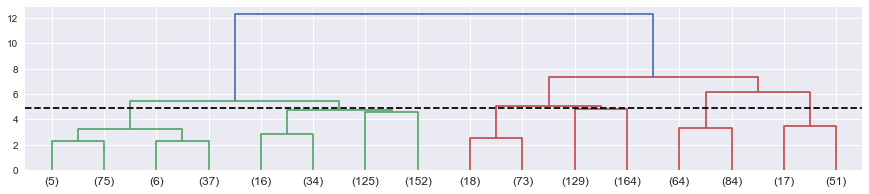

In [75]:
plt.figure(figsize=(15, 3), edgecolor='black')
plt.axhline(4.9, c='k', linestyle='--')
_ = dendrogram(linkage_matrix, orientation='top', p=3, truncate_mode='level')

Il y a deux clusters très apparents.  La découpe en plus de deux clusters est problématique.  
Pas adapté à notre problème.

#### Affinity Propagation

La préférence a été variée de -1e5 à 1e5, mais aucune convergence n'a été observée avec n_iter=10000.

In [1620]:
model = AffinityPropagation(random_state=0, max_iter=10000, preference=-1000)
model.fit(descriptions_w2v_vectorized)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:250: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



AffinityPropagation(max_iter=10000, preference=-1000, random_state=0)

In [1621]:
model.n_iter_

10000

#### Mean Shift

In [76]:
model = MeanShift(bandwidth=0.95)
model.fit(descriptions_w2v_vectorized)

MeanShift(bandwidth=0.95)

In [77]:
model.n_iter_

5

In [78]:
labels_ = model.labels_
print("Nb de clusters :", len(np.unique(labels_)))
print("Effectifs des clusters :")
bincounts = np.bincount(labels_)
print(bincounts)
print("Fréquences :")
print([round(bincount / sum(bincounts) * 100 * 10) / 10 for bincount in bincounts])

Nb de clusters : 7
Effectifs des clusters :
[1044    1    1    1    1    1    1]
Fréquences :
[99.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [79]:
cprint("ARI : {:.2f}".format(adjusted_rand_score(df_source['label'], labels_)), 'red')

ARI : 0.00


Gros point faible de cet algo sur notre jeu de données : le plus gros cluster est systématiquement trop gros (il contient une proportion trop importante des effectifs) par rapport aux autres clusters.

#### BIRCH

In [80]:
model = Birch(n_clusters=7)
model.fit(descriptions_w2v_vectorized)

Birch(n_clusters=7)

In [81]:
labels_ = model.labels_
print("Nb de clusters :", len(np.unique(labels_)))
print("Effectifs des clusters :")
bincounts = np.bincount(labels_)
print(bincounts)
print("Fréquences :")
print([round(bincount / sum(bincounts) * 100 * 10) / 10 for bincount in bincounts])

Nb de clusters : 7
Effectifs des clusters :
[105  62 241 523  78  40   1]
Fréquences :
[10.0, 5.9, 23.0, 49.8, 7.4, 3.8, 0.1]


In [82]:
cprint("ARI : {:.2f}".format(adjusted_rand_score(df_source['label'], labels_)), 'red')

ARI : 0.11


### Plongements

#### t-SNE

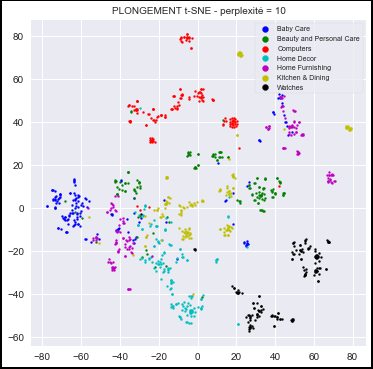

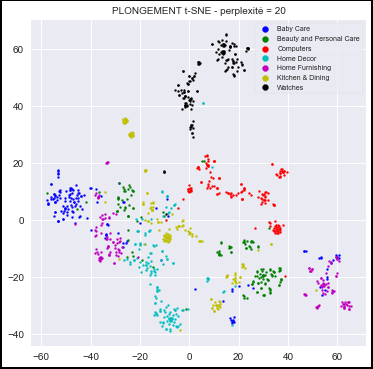

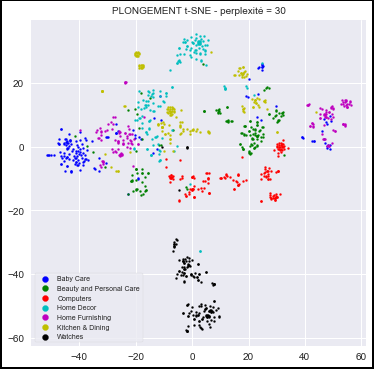

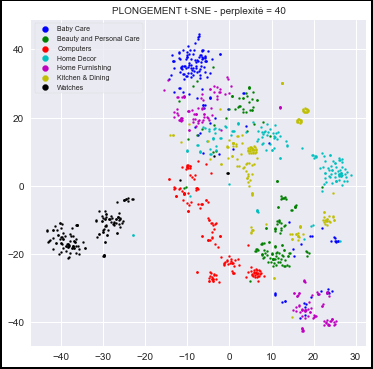

In [83]:
perplexities = [10, 20, 30, 40]

draw_tsne(feat_pca, perplexities, df_source['label'])

#### UMAP

Visualisations moins pertinentes lorsqu'on part de données centrées réduites.

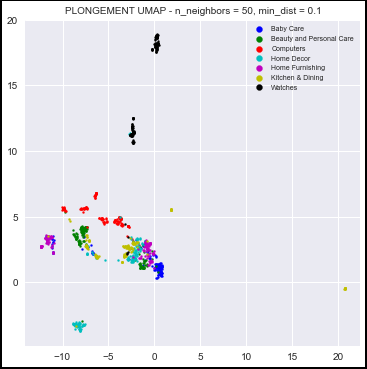

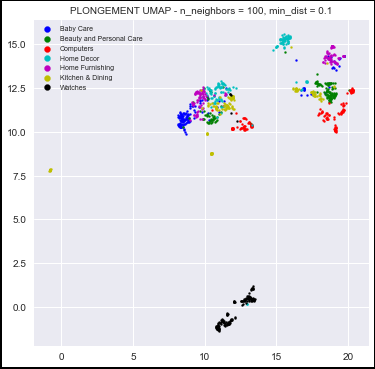

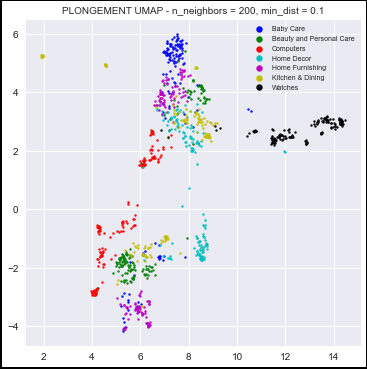

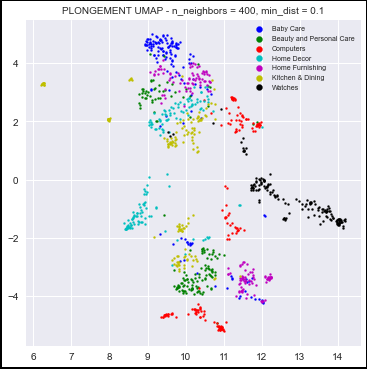

In [84]:
for n_neighbors in (50, 100, 200, 400):
    draw_umap(descriptions_w2v_vectorized, df_source['label'], n_neighbors)

On voit une séparation des 7 labels (particulièrement pour n_neighbors = (100, 200) , mais en un nb élevé de clusters.

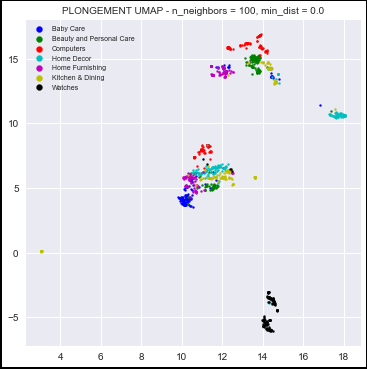

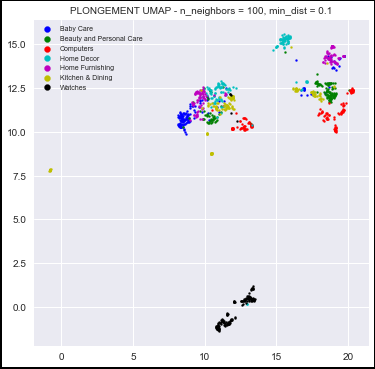

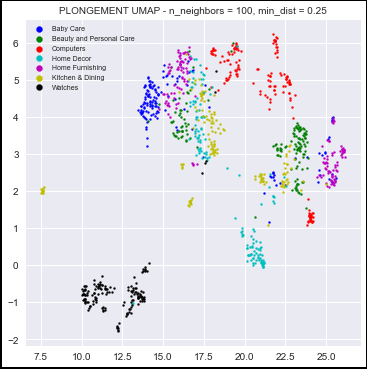

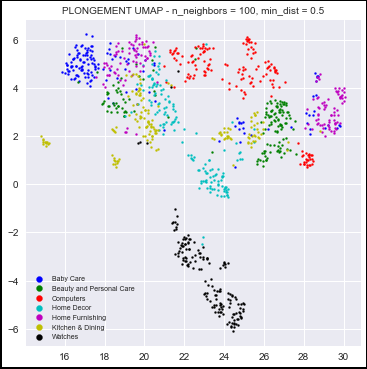

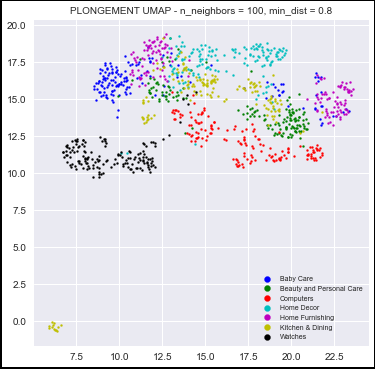

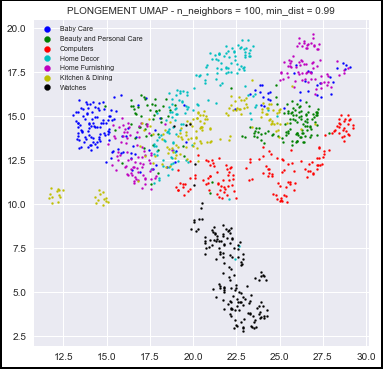

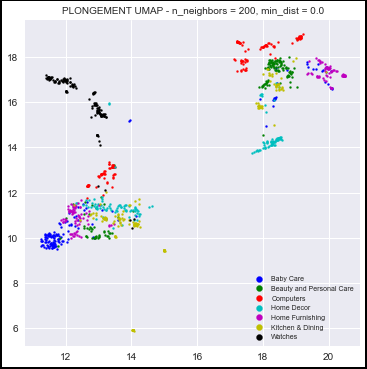

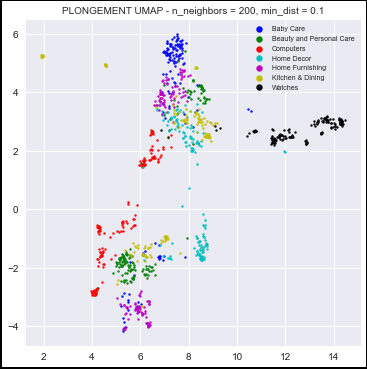

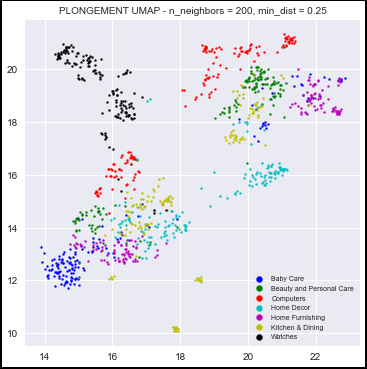

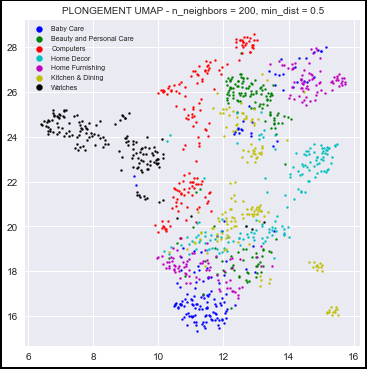

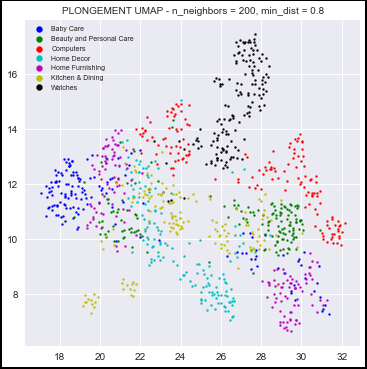

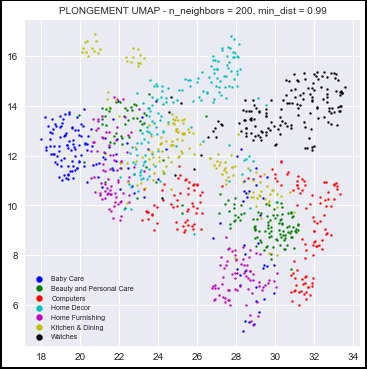

In [85]:
for n_neighbors in (100, 200):
    for min_dist in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
        draw_umap(descriptions_w2v_vectorized, df_source['label'], n_neighbors, min_dist)

### UMAP + clustering

#### Réduction de dimension par UMAP

In [86]:
umap_embedding = umap.UMAP(n_neighbors=100, min_dist=0.8, n_components=20).fit_transform(descriptions_w2v_vectorized) 
print("Dimension des données réduites :", umap_embedding.shape)

Dimension des données réduites : (1050, 20)


#### Clustering k-means

###### k=7

In [87]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=100, tol=1e-10)
km.fit(umap_embedding)
cprint("Adjusted Rand Index: %.2f" %
      adjusted_rand_score(df_source['label'], km.labels_), 'red')

Adjusted Rand Index: 0.35


###### k variable

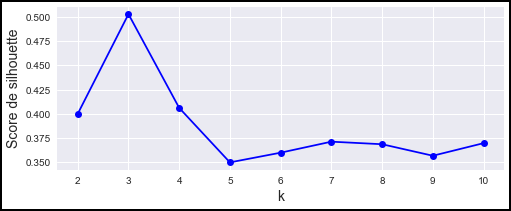

In [88]:
silhouette_scores = []
for n in range(2, 11):
    km = KMeans(n_clusters=n, init='k-means++', max_iter=1000, n_init=100, tol=1e-10)
    km.fit(umap_embedding)
    silhouette_scores.append(silhouette_score(umap_embedding, km.labels_))

plt.style.use('seaborn')
plt.figure(figsize=(8, 3), edgecolor='black', linewidth=4)
plt.plot(range(2, len(silhouette_scores)+2), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("Score de silhouette", fontsize=14)
plt.show()

#### Clustering DBSCAN

In [89]:
clustering = DBSCAN(eps=0.95, min_samples=10).fit(umap_embedding)

In [90]:
label_list = np.unique(clustering.labels_)
label_list

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [91]:
collections.Counter(clustering.labels_)

Counter({0: 582, 1: 135, -1: 58, 2: 252, 3: 11, 4: 12})

Conclusion DBSCAN : la répartition des clusters est trop déséquilibrée

### Classification par SVM

In [92]:
accuracy_svm(feat_pca, df_source['int_label'], n_run=100)

Accuracy : moyenne = 0.933, écart-type = 0.013


## Modèle entrainé sur dataset Flipkart

Les mots de ce modèle ont été stemmed.
  
Méthodologie inspirée de https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py  
et de https://machinelearningmastery.com/develop-word-embeddings-python-gensim/  

### Entrainement du modèle

In [93]:
from gensim.models import Word2Vec
# train model
dimension = 100
# fk_model = Word2Vec(sentences=descriptions_w2v_fk,
#                     min_count=5,
#                     vector_size=dimension,
#                     window=4,
#                     compute_loss=True,
#                     negative=0,
#                     sg=0,
#                     hs=0,
#                     epochs=100,
#                     alpha=1e-3,
#                     min_alpha=1e-8)
fk_model = Word2Vec(sentences=descriptions_w2v_fk)

In [94]:
fk_model.get_latest_training_loss()

0.0

In [95]:
for index, word in enumerate(fk_model.wv.index_to_key):
    if index == 10:
        break
    print(f"#{index}/{len(fk_model.wv.index_to_key)} : {word}")

#0/1379 : product
#1/1379 : free
#2/1379 : rs
#3/1379 : buy
#4/1379 : replac
#5/1379 : ship
#6/1379 : cm
#7/1379 : deliveri
#8/1379 : genuin
#9/1379 : cash


###### t-SNE des mots du modèle

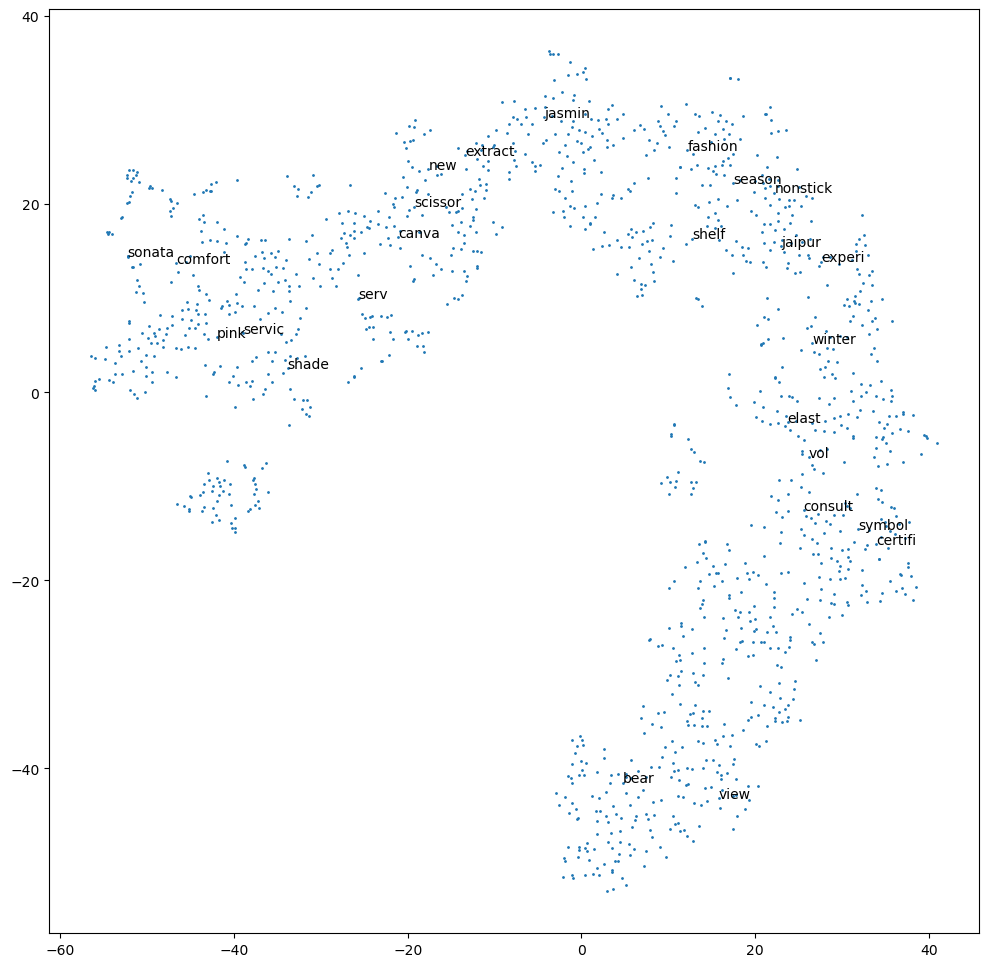

In [1773]:
plt.style.use('default')

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(fk_model)


def plot_with_matplotlib(x_vals, y_vals, labels):
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals, s=1)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_with_matplotlib(x_vals, y_vals, labels)

### Vectorisation du dataset

In [96]:
descriptions_w2v_fk_vectorized = creation_vecteurs_documents(fk_model.wv, dimension, descriptions_w2v_fk)
descriptions_w2v_fk_vectorized.shape

(1050, 100)

### KMeans()

In [97]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=100, tol=1e-10)
km.fit(descriptions_w2v_fk_vectorized)
cprint("Adjusted Rand Index: %.2f" %
      adjusted_rand_score(df_source['label'], km.labels_), 'red')
print("Rand Index: %.2f" % rand_score(df_source['label'], km.labels_))

Adjusted Rand Index: 0.20
Rand Index: 0.79


ARI avec les valeurs par défaut (min_count=5, vector_size=100) : 0.20  
  
ARI avec (min_count=5, vector_size=2) : 0.16  
ARI avec (min_count=5, vector_size=5) : 0.21  
ARI avec (min_count=5, vector_size=7) : 0.22  
ARI avec (min_count=5, vector_size=8) : 0.23  ++  
ARI avec (min_count=5, vector_size=9) : 0.22  
ARI avec (min_count=5, vector_size=10) : 0.22  
ARI avec (min_count=5, vector_size=20) : 0.22  
ARI avec (min_count=5, vector_size=50) : 0.22  
ARI avec (min_count=5, vector_size=100) : 0.20     (défaut de Word2Vec)  
ARI avec (min_count=5, vector_size=200) : 0.19   

ARI avec (min_count=1, vector_size=8) : 0.20  
ARI avec (min_count=4, vector_size=8) : 0.20  
ARI avec (min_count=5, vector_size=8) : 0.23  
ARI avec (min_count=10, vector_size=8) : 0.22  
ARI avec (min_count=20, vector_size=8) : 0.23  
ARI avec (min_count=50, vector_size=8) : 0.24  
ARI avec (min_count=100, vector_size=8) : 0.26  ++  
ARI avec (min_count=150, vector_size=8) : 0.25  
ARI avec (min_count=200, vector_size=8) : 0.14  

ARI avec (min_count=100, vector_size=5) : 0.24  
ARI avec (min_count=100, vector_size=6) : 0.26  
ARI avec (min_count=100, vector_size=7) : 0.26    
ARI avec (min_count=100, vector_size=8) : 0.26  ++  
ARI avec (min_count=100, vector_size=9) : 0.24  
ARI avec (min_count=100, vector_size=10) : 0.24  
ARI avec (min_count=100, vector_size=15) : 0.24  
ARI avec (min_count=100, vector_size=100) : 0.24  

ARI avec (min_count=100, vector_size=8, window=3) : 0.24  
ARI avec (min_count=100, vector_size=8, window=3) : 0.25  
ARI avec (min_count=100, vector_size=8, window=4) : 0.25  ++  
ARI avec (min_count=100, vector_size=8, window=5) : 0.26  
ARI avec (min_count=100, vector_size=8, window=6) : 0.20  
ARI avec (min_count=100, vector_size=8, window=7) : 0.20  
ARI avec (min_count=100, vector_size=8, window=8) : 0.20  

ARI avec (min_count=100, vector_size=8, window=4, negative=0) : 0.28  ++
ARI avec (min_count=100, vector_size=8, window=4, negative=1) : 0.24  
ARI avec (min_count=100, vector_size=8, window=4, negative=2) : 0.25  
ARI avec (min_count=100, vector_size=8, window=4, negative=3) : 0.25  
ARI avec (min_count=100, vector_size=8, window=4, negative=5) : 0.25  
ARI avec (min_count=100, vector_size=8, window=4, negative=10) : 0.26  
ARI avec (min_count=100, vector_size=8, window=4, negative=20) : 0.20  

sg: Training algorithm: 1 for skip-gram; otherwise CBOW.  
ARI avec (sg=0) : 0.20  
ARI avec (sg=1) : 0.20  

hs : If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.  
ARI avec (sg=0, hs=0) : 0.20  
ARI avec (sg=0, hs=1) : 0.23  ++
ARI avec (sg=1, hs=1) : 0.21  
ARI avec (min_count=100, vector_size=8, window=4, negative=0, sg=0, hs=1) : 0.20  

epochs – Number of iterations (epochs) over the corpus  (default : 5)  
ARI (paramètres par défaut, epochs=5) : 0.20  
ARI (paramètres par défaut, epochs=20) : 0.24  
ARI (paramètres par défaut, epochs=100) : 0.28  
ARI (paramètres par défaut, epochs=1000) : 0.28  

ARI avec (min_count=100, vector_size=8, window=4, negative=0, epochs=100) : 0.27

alpha – The initial learning rate.  
min_alpha – Learning rate will linearly drop to min_alpha as training progresses.  
Modifier alpha et min_alpha (avec epochs suffisants) n'a pas d'effet amélioratif sur l'ARI. En revanche la valeur obtenue pour l'ARI oscille moins lors de reruns consécutifs.  

In [98]:
for i in range(len(km.cluster_centers_)):
    cprint("Cluster %d:" % i, 'red', end='')
    print(fk_model.wv.most_similar(km.cluster_centers_[i]))
    print()

Cluster 0:[('genuin', 0.9974121451377869), ('guarante', 0.9967095851898193), ('replac', 0.9963739514350891), ('free', 0.9955847859382629), ('day', 0.9950900673866272), ('rs', 0.9950799345970154), ('ship', 0.9947508573532104), ('cash', 0.9930052757263184), ('product', 0.9926837086677551), ('deliveri', 0.9889620542526245)]

Cluster 1:[('keep', 0.9989436864852905), ('item', 0.9987079501152039), ('panel', 0.998584508895874), ('bowl', 0.9985644817352295), ('duvet', 0.9985619187355042), ('bed', 0.9984493255615234), ('long', 0.9983872771263123), ('piec', 0.9983617067337036), ('hot', 0.9982539415359497), ('lead', 0.9982162117958069)]

Cluster 2:[('rs', 0.9943132400512695), ('guarante', 0.9931554198265076), ('genuin', 0.992854654788971), ('replac', 0.9923504590988159), ('free', 0.9920322299003601), ('day', 0.9902207851409912), ('ship', 0.9898255467414856), ('product', 0.9891858696937561), ('cash', 0.988050639629364), ('combo', 0.9825710654258728)]

Cluster 3:[('neck', 0.9959858059883118), ('gat

### Visualisation par t-SNE

On fait une réduction de dimension par PCA au préalable (conservation de 99% de l'inertie).

Dimensions dataset avant réduction PCA :  (1050, 100)
Dimensions dataset après réduction PCA :  (1050, 5)


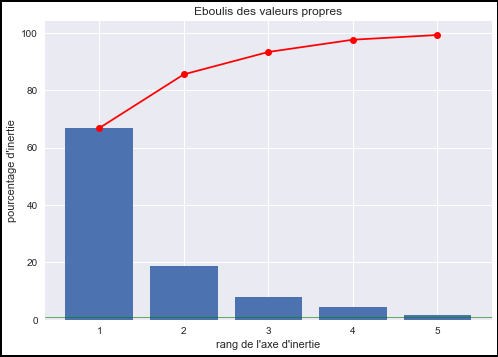

In [99]:
print("Dimensions dataset avant réduction PCA : ", descriptions_w2v_fk_vectorized.shape)
pca = decomposition.PCA(n_components=0.99)
X_scaled = preprocessing.StandardScaler().fit_transform(descriptions_w2v_fk_vectorized)   # données centrées réduites
feat_pca= pca.fit_transform(X_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
display_scree_plot(pca)

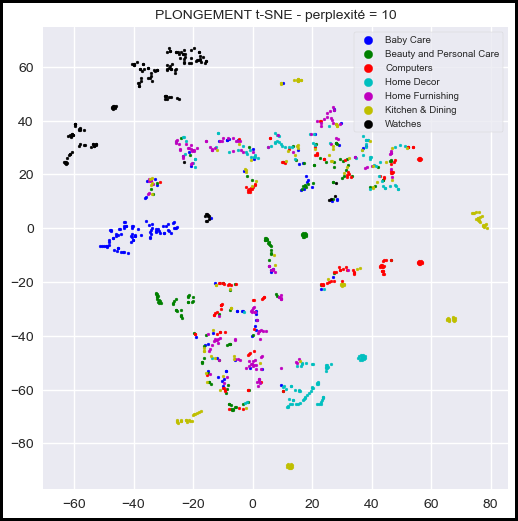

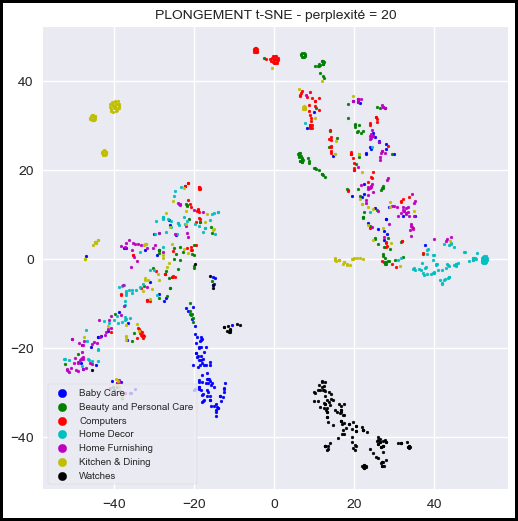

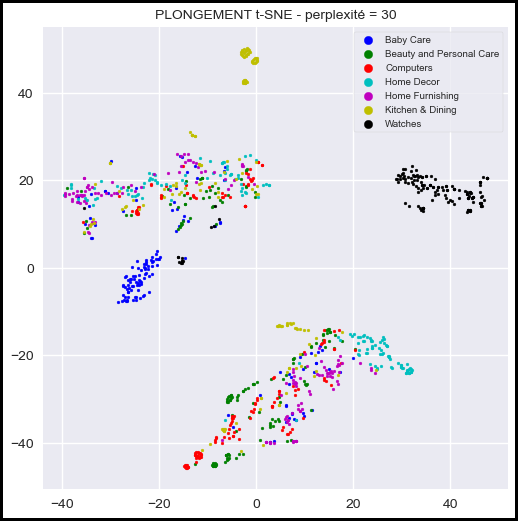

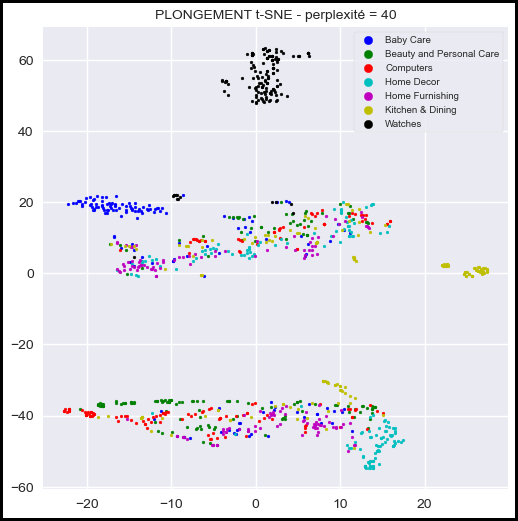

In [1817]:
perplexities = [10, 20, 30, 40]

draw_tsne(feat_pca, perplexities, df_source['label'])

### Classification par SVM

In [100]:
accuracy_svm(feat_pca, df_source['int_label'], 100)

Accuracy : moyenne = 0.690, écart-type = 0.025
